In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from data import DataProvider
import typing as T
import numpy as np

In [2]:
provider = DataProvider()
raw_df = provider.read_excel()
scaled_df = provider.scale_data(raw_df)

In [3]:
charging_df_0_2 = provider.get_charging_data(scaled_df, 0, -2)
charging_df_2_8 = provider.get_charging_data(scaled_df, -2, -8)
charging_df_8_14 = provider.get_charging_data(scaled_df, -8, -14)

charging_dfs = [charging_df_0_2, charging_df_2_8, charging_df_8_14]
rangesStrings = ["0A - 2A", "2A - 8A", "8A - 14A"]

In [4]:
from SingleANNBenchmaker import SingleANNBenchmaker
from utils import predict_and_plot

benchmaker = SingleANNBenchmaker()
benchmark_results = benchmaker.run_benchmark(charging_dfs, rangesStrings)


⚡ Processing Charging Range 1 (0A - 2A): Current ∈ [-2.0, 0.0] A
  -> Training model: ReLU...
  ✅ Done. MAE: 0.3859 V | R²: 0.6537 | Epochs: 47
  -> Training model: LeakyReLU...


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


  ✅ Done. MAE: 0.3760 V | R²: 0.6691 | Epochs: 142
  -> Training model: Tanh...
  ✅ Done. MAE: 0.4197 V | R²: 0.6235 | Epochs: 15
  -> Training model: GELU...
  ✅ Done. MAE: 0.4058 V | R²: 0.6269 | Epochs: 15

⚡ Processing Charging Range 2 (2A - 8A): Current ∈ [-8.0, -2.0] A
  -> Training model: ReLU...
  ✅ Done. MAE: 0.1933 V | R²: 0.7651 | Epochs: 33
  -> Training model: LeakyReLU...


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


  ✅ Done. MAE: 0.2700 V | R²: 0.6402 | Epochs: 15
  -> Training model: Tanh...
  ✅ Done. MAE: 0.2407 V | R²: 0.6875 | Epochs: 15
  -> Training model: GELU...
  ✅ Done. MAE: 0.2784 V | R²: 0.6271 | Epochs: 15

⚡ Processing Charging Range 3 (8A - 14A): Current ∈ [-14.0, -8.0] A
  -> Training model: ReLU...
  ✅ Done. MAE: 0.2453 V | R²: 0.6499 | Epochs: 15
  -> Training model: LeakyReLU...


c:\Users\dimaherez\StudioProjects\battery-model-ann\.venv\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


  ✅ Done. MAE: 0.2504 V | R²: 0.6359 | Epochs: 15
  -> Training model: Tanh...
  ✅ Done. MAE: 0.2246 V | R²: 0.6762 | Epochs: 15
  -> Training model: GELU...
  ✅ Done. MAE: 0.2232 V | R²: 0.6587 | Epochs: 15



--- Visualizing Best Model: 0A - 2A_ReLU ---
  -> MAE of Model: 0.3859
  -> MSE of Model: 0.279637
  -> R2 of Model: 0.653719
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

--- Metrics vs. Smoothed Baseline for '0A - 2A_ReLU' ---
  Smoothed MAE: 0.1574 V
  Smoothed MSE: 0.0412
  Smoothed R²:  0.7953
-------------------------------------------------


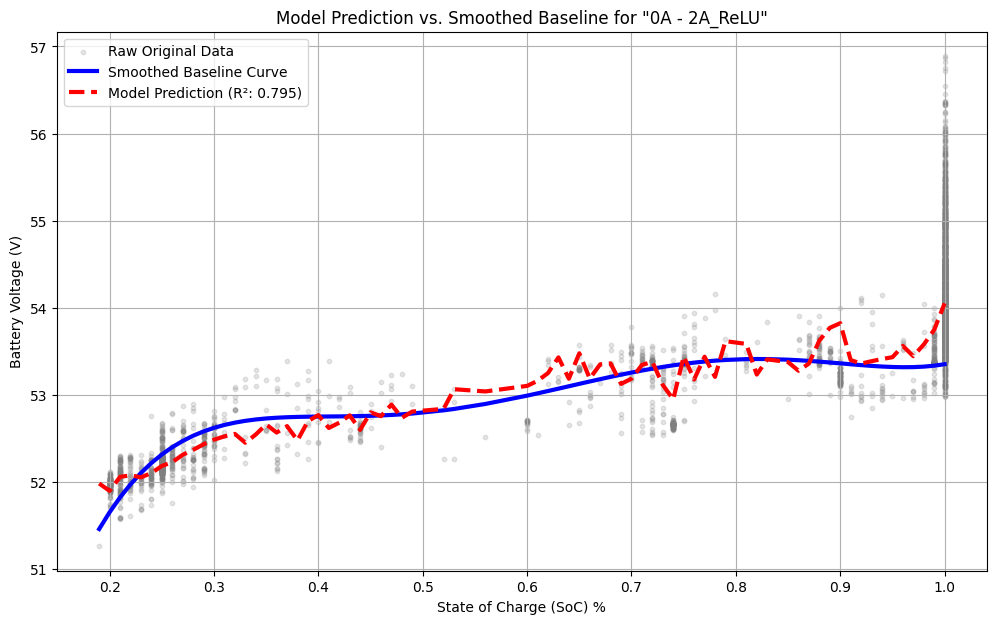


--- Visualizing Best Model: 0A - 2A_LeakyReLU ---
  -> MAE of Model: 0.3760
  -> MSE of Model: 0.267183
  -> R2 of Model: 0.669141
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 

--- Metrics vs. Smoothed Baseline for '0A - 2A_LeakyReLU' ---
  Smoothed MAE: 0.1385 V
  Smoothed MSE: 0.0366
  Smoothed R²:  0.8186
-------------------------------------------------


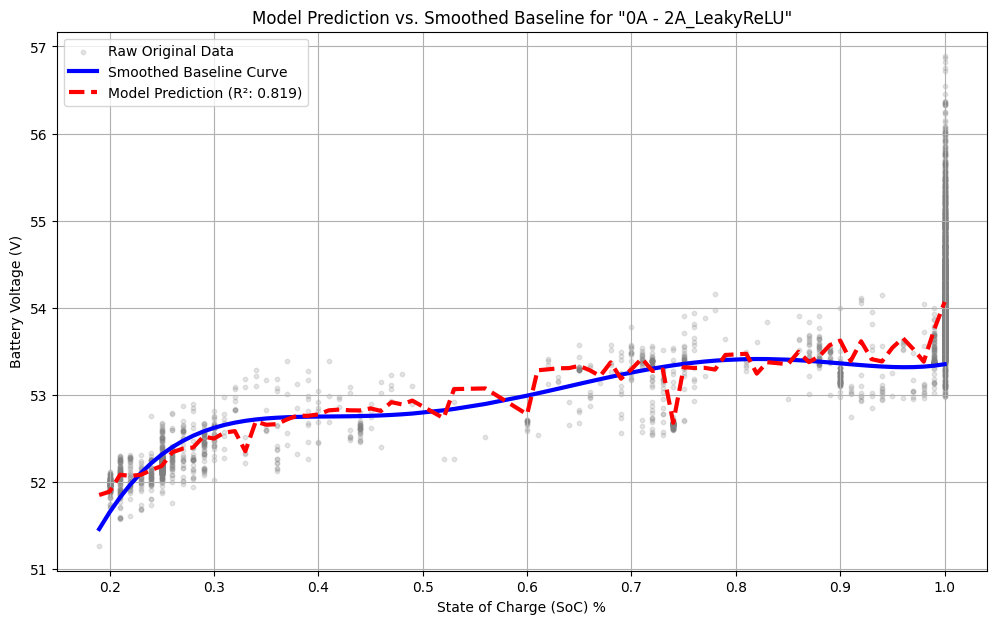


--- Visualizing Best Model: 0A - 2A_Tanh ---
  -> MAE of Model: 0.4197
  -> MSE of Model: 0.304029
  -> R2 of Model: 0.623513
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

--- Metrics vs. Smoothed Baseline for '0A - 2A_Tanh' ---
  Smoothed MAE: 0.2561 V
  Smoothed MSE: 0.1000
  Smoothed R²:  0.5039
-------------------------------------------------


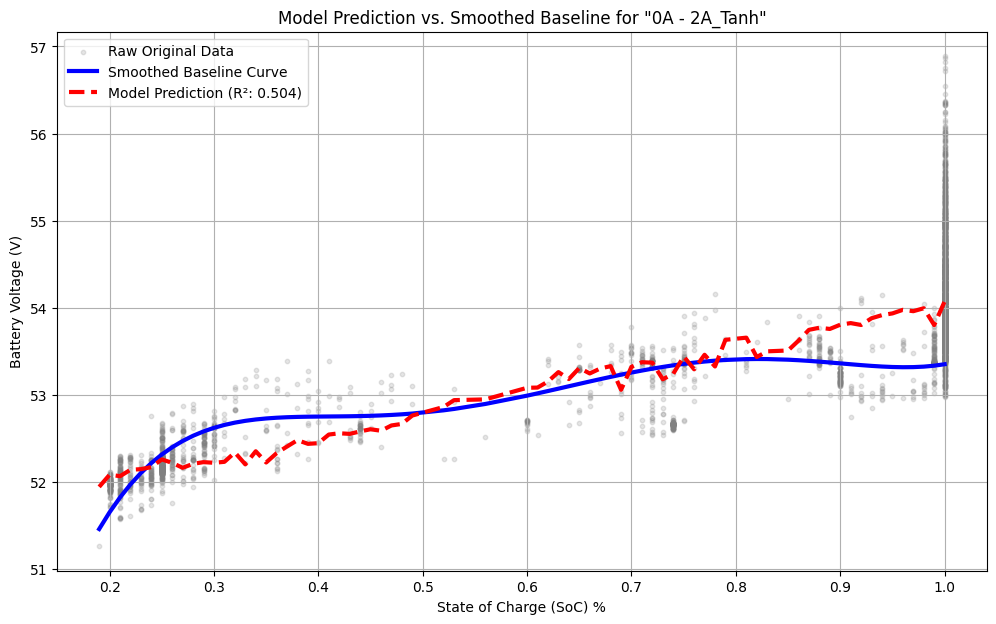


--- Visualizing Best Model: 0A - 2A_GELU ---
  -> MAE of Model: 0.4058
  -> MSE of Model: 0.301262
  -> R2 of Model: 0.626940
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step

--- Metrics vs. Smoothed Baseline for '0A - 2A_GELU' ---
  Smoothed MAE: 0.2499 V
  Smoothed MSE: 0.0902
  Smoothed R²:  0.5522
-------------------------------------------------


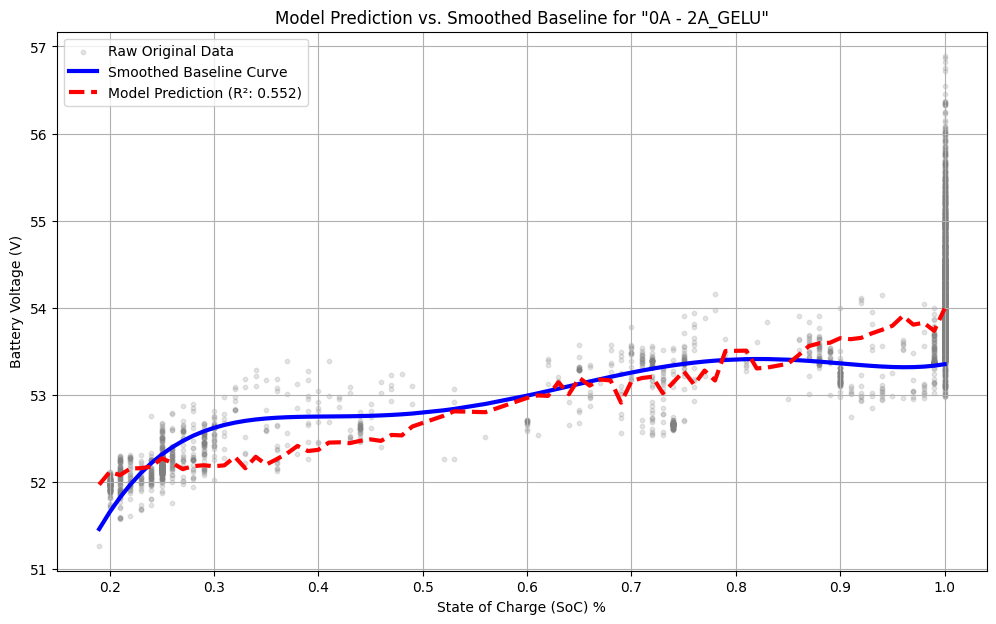


--- Visualizing Best Model: 2A - 8A_ReLU ---
  -> MAE of Model: 0.1933
  -> MSE of Model: 0.083306
  -> R2 of Model: 0.765120
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

--- Metrics vs. Smoothed Baseline for '2A - 8A_ReLU' ---
  Smoothed MAE: 0.0886 V
  Smoothed MSE: 0.0118
  Smoothed R²:  0.9361
-------------------------------------------------


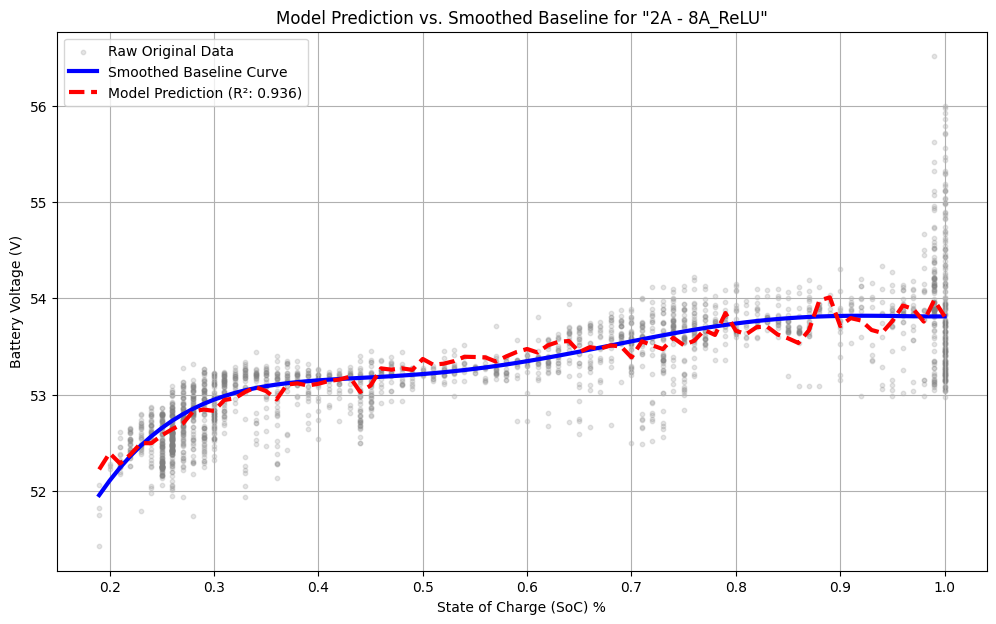


--- Visualizing Best Model: 2A - 8A_LeakyReLU ---
  -> MAE of Model: 0.2700
  -> MSE of Model: 0.127623
  -> R2 of Model: 0.640169
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

--- Metrics vs. Smoothed Baseline for '2A - 8A_LeakyReLU' ---
  Smoothed MAE: 0.1786 V
  Smoothed MSE: 0.0454
  Smoothed R²:  0.7548
-------------------------------------------------


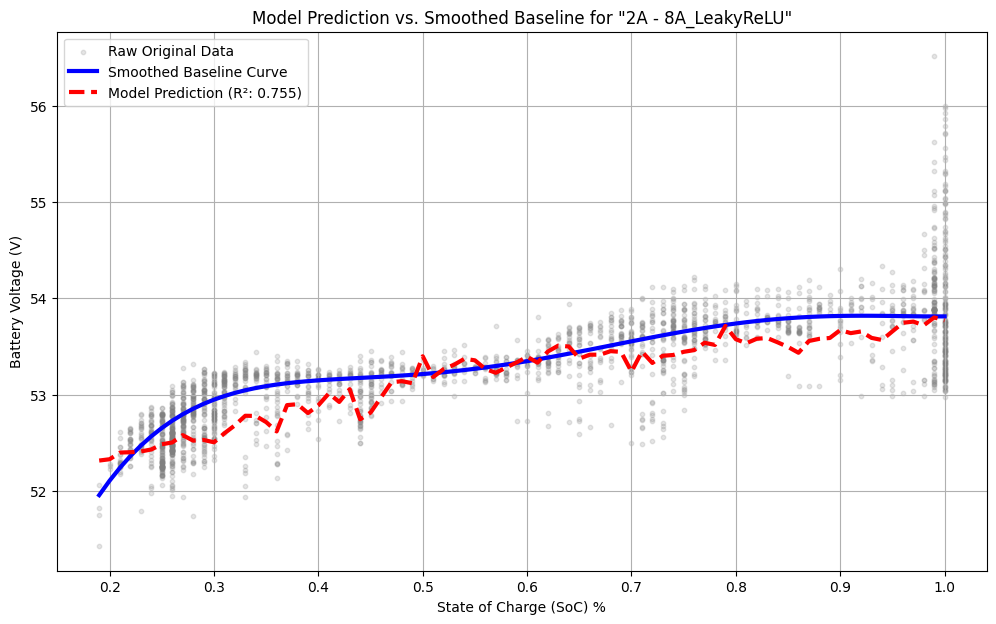


--- Visualizing Best Model: 2A - 8A_Tanh ---
  -> MAE of Model: 0.2407
  -> MSE of Model: 0.110827
  -> R2 of Model: 0.687525
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

--- Metrics vs. Smoothed Baseline for '2A - 8A_Tanh' ---
  Smoothed MAE: 0.1126 V
  Smoothed MSE: 0.0228
  Smoothed R²:  0.8769
-------------------------------------------------


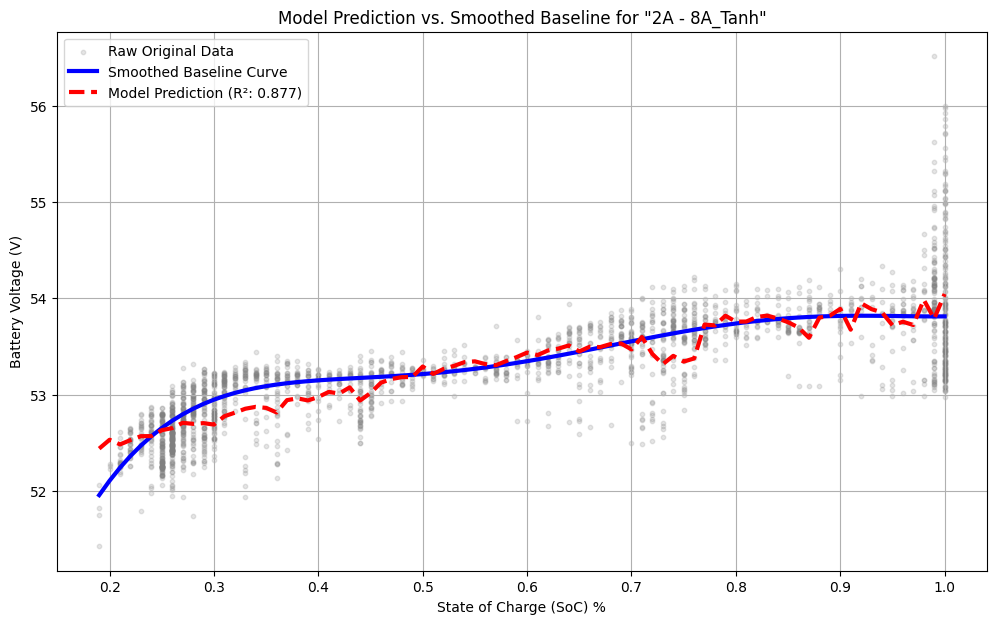


--- Visualizing Best Model: 2A - 8A_GELU ---
  -> MAE of Model: 0.2784
  -> MSE of Model: 0.132268
  -> R2 of Model: 0.627074
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 

--- Metrics vs. Smoothed Baseline for '2A - 8A_GELU' ---
  Smoothed MAE: 0.1701 V
  Smoothed MSE: 0.0406
  Smoothed R²:  0.7809
-------------------------------------------------


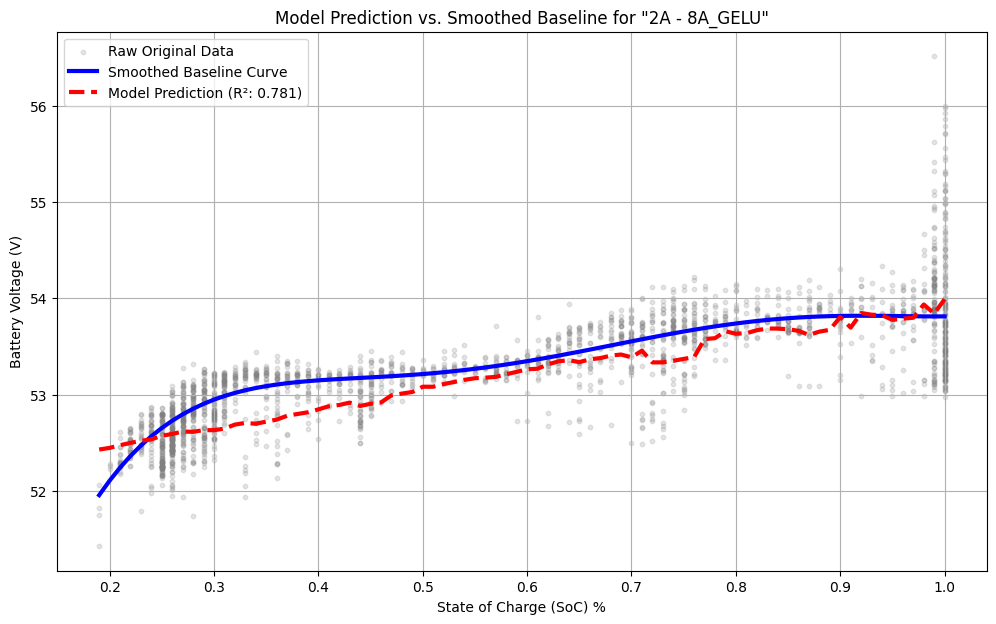


--- Visualizing Best Model: 8A - 14A_ReLU ---
  -> MAE of Model: 0.2453
  -> MSE of Model: 0.120412
  -> R2 of Model: 0.649871
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

--- Metrics vs. Smoothed Baseline for '8A - 14A_ReLU' ---
  Smoothed MAE: 0.1244 V
  Smoothed MSE: 0.0240
  Smoothed R²:  0.8477
-------------------------------------------------


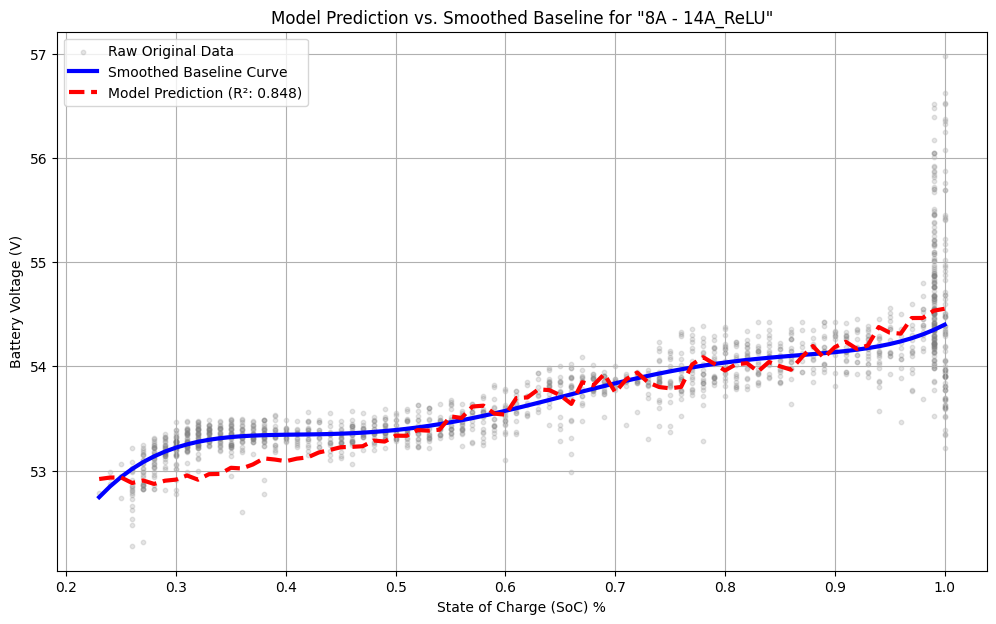


--- Visualizing Best Model: 8A - 14A_LeakyReLU ---
  -> MAE of Model: 0.2504
  -> MSE of Model: 0.125208
  -> R2 of Model: 0.635924
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

--- Metrics vs. Smoothed Baseline for '8A - 14A_LeakyReLU' ---
  Smoothed MAE: 0.1196 V
  Smoothed MSE: 0.0191
  Smoothed R²:  0.8792
-------------------------------------------------


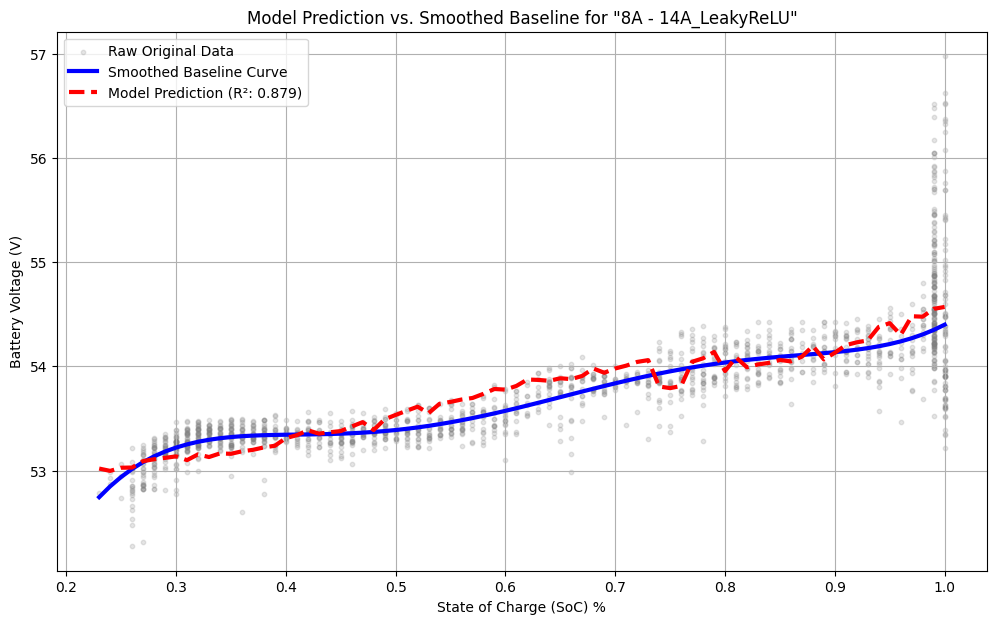


--- Visualizing Best Model: 8A - 14A_Tanh ---
  -> MAE of Model: 0.2246
  -> MSE of Model: 0.111369
  -> R2 of Model: 0.676164
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

--- Metrics vs. Smoothed Baseline for '8A - 14A_Tanh' ---
  Smoothed MAE: 0.1017 V
  Smoothed MSE: 0.0129
  Smoothed R²:  0.9184
-------------------------------------------------


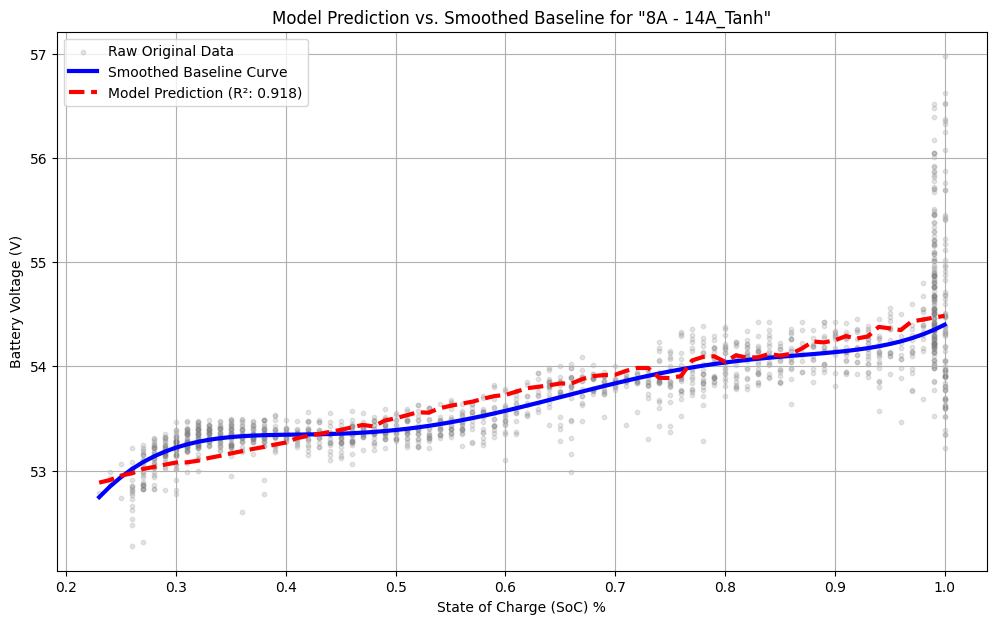


--- Visualizing Best Model: 8A - 14A_GELU ---
  -> MAE of Model: 0.2232
  -> MSE of Model: 0.117384
  -> R2 of Model: 0.658675
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

--- Metrics vs. Smoothed Baseline for '8A - 14A_GELU' ---
  Smoothed MAE: 0.0931 V
  Smoothed MSE: 0.0133
  Smoothed R²:  0.9157
-------------------------------------------------


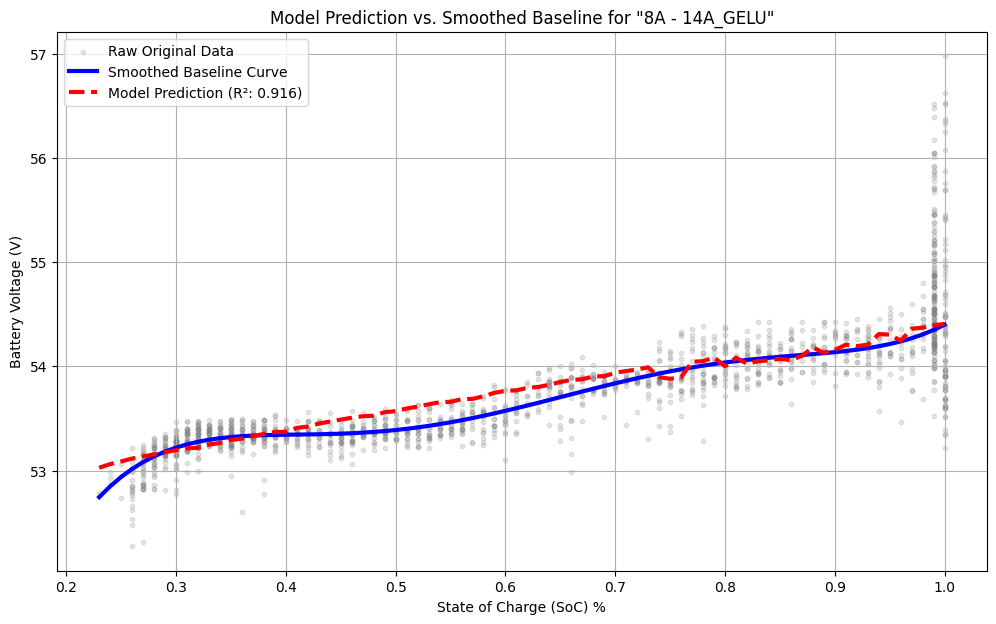

In [5]:
# --- Select the best result to visualize ---
for key, result in benchmark_results.items():
    y_true = result['y_true'].flatten()
    y_pred = result['y_pred'].flatten()
    df_original = result["df_original"]

    print(f"\n--- Visualizing Best Model: {key} ---")
    print(f"  -> MAE of Model: {result["mae"]:.4f}")
    print(f"  -> MSE of Model: {result["mse"]:.6f}")
    print(f"  -> R2 of Model: {result["r2"]:.6f}")


    predict_and_plot(key, benchmark_results, provider)